In [1]:
import pandas as pd
from google.colab import drive
import pandas as pd
import csv

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Data/ADEnormalizationSOCTop3.tsv'
# Read the CSV file into a DataFrame
data = pd.read_csv(data_path, sep='\t')
# data = pd. DataFrame(data)
# Display the DataFrame
# print(data.head)
# # print(data['ade'],data['soc_code'])
# data['soc_code'].value_counts()
data = data[data['soc_code'] != 0]

print(data.head)

Mounted at /content/drive
<bound method NDFrame.head of       Unnamed: 0                        ade  soc_code
0              2                         AD  10037175
1              3                      focus  10029205
2              4                       died  10018065
3              5                       died  10018065
4              7                     dreams  10037175
...          ...                        ...       ...
1195        1702                 chest hurt  10018065
1196        1703   got ten minutes of sleep  10037175
1197        1706                     orgasm  10037175
1198        1707  never have another orgasm  10037175
1199        1708                       coma  10029205

[1200 rows x 3 columns]>


In [2]:
!pip install transformers
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

# data.head()

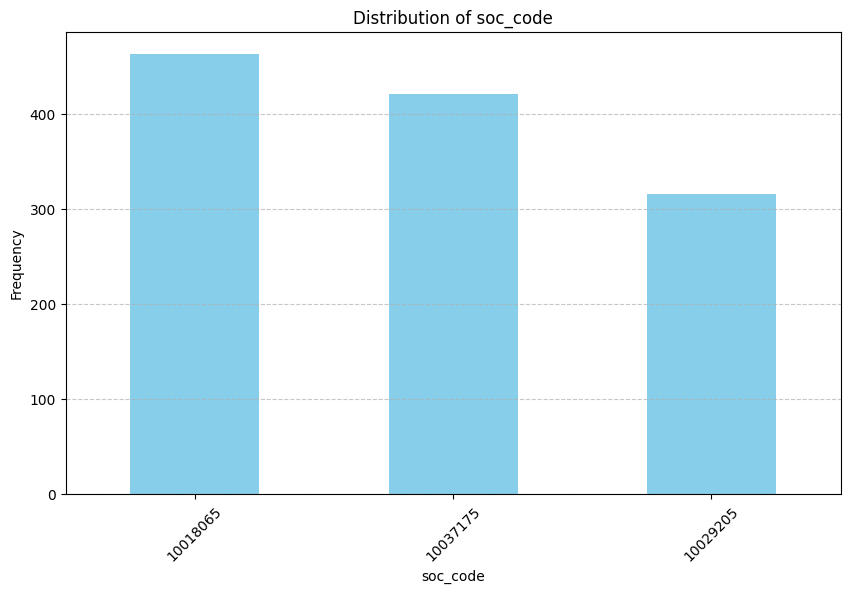

soc_code
10018065    463
10037175    421
10029205    316
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt

#plot data distribution
# Plot soc_code distribution
plt.figure(figsize=(10, 6))
data['soc_code'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of soc_code')
plt.xlabel('soc_code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(data['soc_code'].value_counts())
df = data

In [6]:
import pandas as pd

# Get unique labels and their counts
label_counts = df['soc_code'].value_counts()

# Sort labels by counts
sorted_labels = label_counts.index.tolist()

# Create label dictionary with labels assigned from 1 to the number of unique labels
label_dict = {label: i for i, label in enumerate(sorted_labels, 0)}

# Print label dictionary
print(label_dict)

label_df = pd.DataFrame.from_dict(label_dict, orient='index', columns=['Label'])

# Reset index to make the index a regular column
label_df.reset_index(inplace=True)

# Rename columns
label_df.columns = ['SOC Code', 'Label']

# Sort DataFrame by label
label_df = label_df.sort_values(by='Label')

# Print the DataFrame
print(label_df)

df['label'] = df.soc_code.replace(label_dict)

{10018065: 0, 10037175: 1, 10029205: 2}
   SOC Code  Label
0  10018065      0
1  10037175      1
2  10029205      2


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

def custom_train_test_split(X, y, test_size=0.15, random_state=None):
    classes, counts = np.unique(y, return_counts=True)
    min_class_count = min(counts)

    # Find classes with only one or two instances
    single_or_double_instance_classes = classes[np.logical_or(counts == 1, counts == 2)]

    # Remove instances of single-instance or two-instance classes
    X_filtered = X[~np.isin(y, single_or_double_instance_classes)]
    y_filtered = y[~np.isin(y, single_or_double_instance_classes)]

    if len(y_filtered) < 2:
        raise ValueError("No classes have more than two instances after filtering.")

    # Perform stratified split on the filtered dataset
    X_train, X_val, y_train, y_val = train_test_split(X_filtered, y_filtered, test_size=test_size, random_state=random_state, stratify=y_filtered)

    # Randomly assign instances of single-instance classes to training or testing sets
    for class_label in single_or_double_instance_classes:
        class_indices = np.where(y == class_label)[0]
        np.random.shuffle(class_indices)

        if len(class_indices) <= 2:
            # Only one instance, randomly assign to training or testing set
            if np.random.rand() < test_size:
                X_val = np.concatenate((X_val, X[class_indices]))
                y_val = np.concatenate((y_val, y[class_indices]))
            else:
                X_train = np.concatenate((X_train, X[class_indices]))
                y_train = np.concatenate((y_train, y[class_indices]))

    return X_train, X_val, y_train, y_val

# Usage:
X_train, X_val, y_train, y_val = custom_train_test_split(df.index.values, df.label.values, test_size=0.2, random_state=42)


                          Unnamed: 0  ade
soc_code label data_type                 
10018065 0     train             370  370
               val                93   93
10029205 2     train             253  253
               val                63   63
10037175 1     train             337  337
               val                84   84
   soc_code  label data_type  count
0  10018065      0     train    370
1  10018065      0       val     93
5  10037175      1       val     84
4  10037175      1     train    337
3  10029205      2       val     63
2  10029205      2     train    253


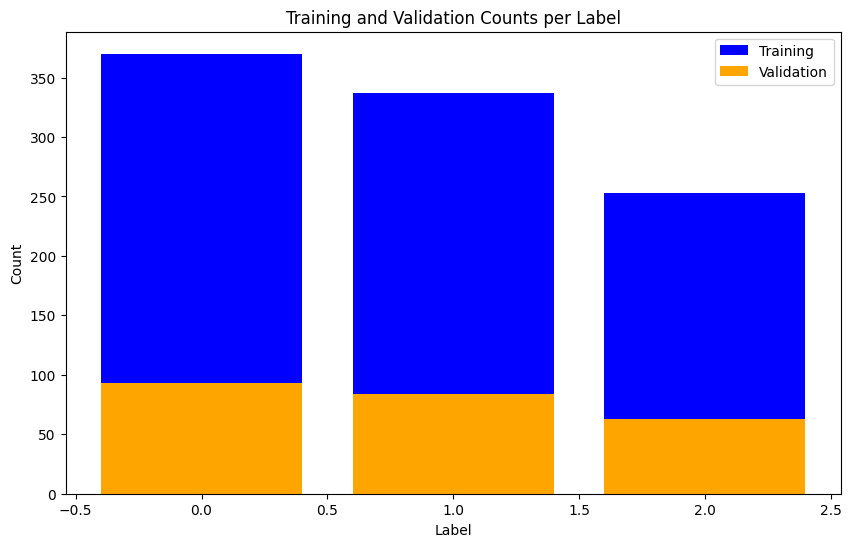

In [12]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

print(df.groupby(['soc_code', 'label', 'data_type']).count())

result = df.groupby(['soc_code', 'label', 'data_type']).size().reset_index(name='count')
result_sorted = result.sort_values(by='label')
print(result_sorted)

import matplotlib.pyplot as plt

# Group by soc_code, label, and data_type
grouped = df.groupby(['soc_code', 'label', 'data_type']).size().reset_index(name='count')

# Filter data for training and validation
train_counts = grouped[grouped['data_type'] == 'train']
val_counts = grouped[grouped['data_type'] == 'val']

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(train_counts['label'], train_counts['count'], color='blue', label='Training')
plt.bar(val_counts['label'], val_counts['count'], color='orange', label='Validation')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Training and Validation Counts per Label')
plt.legend()
plt.show()


In [14]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].ade.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].ade.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerN

In [15]:
#data loader
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

from transformers import AdamW, get_linear_schedule_with_warmup

#training parameters
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

#evaluation
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# Assuming device is cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
model.to(device)
print(f"Device used: {device}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device used: cuda


In [16]:
#training
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)
        # outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)


        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'./finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0907365698367357
Validation loss: 0.8912723700205485
F1 Score (Weighted): 0.5393720663941253


Epoch 2:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7943849766937395
Validation loss: 0.9905393429721395
F1 Score (Weighted): 0.5833954008353918


Epoch 3:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5704602014273406
Validation loss: 0.8947354583380123
F1 Score (Weighted): 0.7150140491403879


Epoch 4:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4663612757702746
Validation loss: 1.261674234631937
F1 Score (Weighted): 0.7400066882749397


Epoch 5:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.41129675183910874
Validation loss: 1.4193431444912372
F1 Score (Weighted): 0.7146040714011674


Epoch 6:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.3519472770698485
Validation loss: 1.4891951781173702
F1 Score (Weighted): 0.7473599974180903


Epoch 7:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.31114667393194395
Validation loss: 1.4933628013866838
F1 Score (Weighted): 0.7441855276185696


Epoch 8:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.26419607239658943
Validation loss: 1.454079606102702
F1 Score (Weighted): 0.7780290641367428


Epoch 9:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.17593803875048858
Validation loss: 1.5941054020882197
F1 Score (Weighted): 0.7636043232022384


Epoch 10:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.1662488707091446
Validation loss: 1.688642717137312
F1 Score (Weighted): 0.7655453950698053


Epoch 11:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.10614659715502058
Validation loss: 1.8089524685271803
F1 Score (Weighted): 0.7628388278388277


Epoch 12:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.09943508994844402
Validation loss: 1.7146185312172748
F1 Score (Weighted): 0.7793971764757052


Epoch 13:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.1086651960307184
Validation loss: 1.9253071512824438
F1 Score (Weighted): 0.7692185762246775


Epoch 14:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.0818482225059294
Validation loss: 1.970414726671758
F1 Score (Weighted): 0.7723742685267253


Epoch 15:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.0902011277942923
Validation loss: 1.7459568461856785
F1 Score (Weighted): 0.789096452037324


Epoch 16:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.06967111376352478
Validation loss: 1.7742023864579095
F1 Score (Weighted): 0.778183878736365


Epoch 17:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.04686248739362782
Validation loss: 1.786566859376641
F1 Score (Weighted): 0.7841616722254755


Epoch 18:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.05788002544456201
Validation loss: 1.8458838209275805
F1 Score (Weighted): 0.7801513994331498


Epoch 19:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.05228582202271355
Validation loss: 1.857896121127366
F1 Score (Weighted): 0.7849831613669692


Epoch 20:   0%|          | 0/240 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.03757382329289006
Validation loss: 1.8575567876042138
F1 Score (Weighted): 0.7801513994331498


In [17]:
#evaluation
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('./finetuned_BERT_epoch_20.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class: 10018065
Accuracy: 74/93

Class: 10037175
Accuracy: 64/84

Class: 10029205
Accuracy: 49/63



{0: 0.7956989247311828, 1: 0.7619047619047619, 2: 0.7777777777777778} {0: 93, 1: 84, 2: 63}


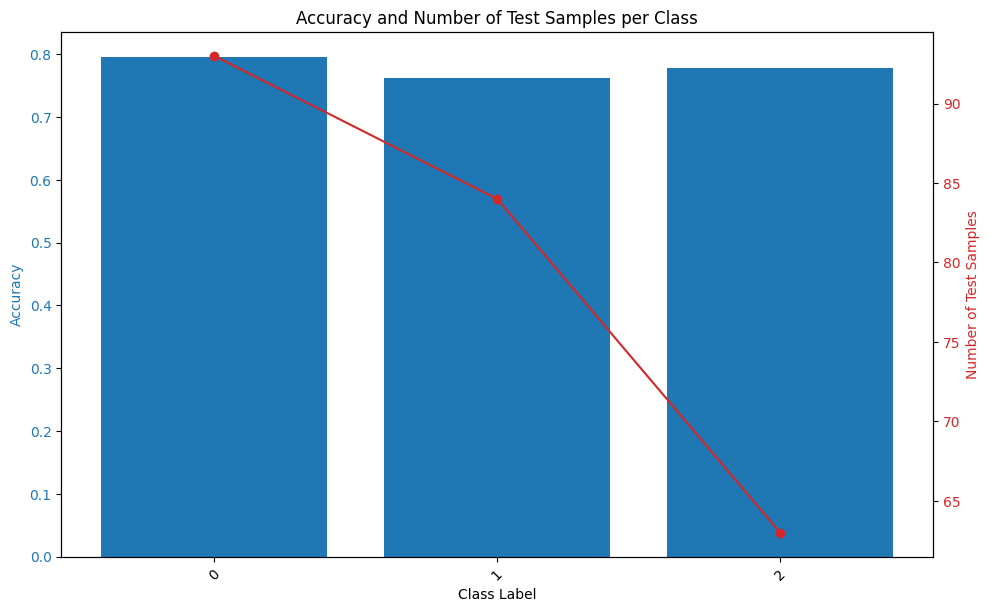

In [18]:
#plot evaluation
import matplotlib.pyplot as plt

def accuracy_per_class(predictions, true_vals):
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()
    accuracy_dict = {}
    count_dict = {}
    for label in np.unique(labels_flat):
        y_preds = pred_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        accuracy_dict[label] = np.sum(y_preds == y_true) / len(y_true)
        count_dict[label] = len(y_true)
    return accuracy_dict, count_dict

accuracy_dict, count_dict = accuracy_per_class(predictions, true_vals)

print(accuracy_dict, count_dict )

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
color = 'tab:blue'
ax1.set_xlabel('Class Label')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(accuracy_dict.keys(), accuracy_dict.values(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Show class labels instead of class indices
ax1.set_xticks(list(accuracy_dict.keys()))
ax1.set_xticklabels(list(accuracy_dict.keys()), rotation=45)

# Plot number of samples
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Test Samples', color=color)
ax2.plot(count_dict.keys(), count_dict.values(), color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Accuracy and Number of Test Samples per Class')
plt.show()
